In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn import model_selection
from scipy.stats import pearsonr
import reverse_geocoder as rg 
from datetime import date
import calendar
from sklearn import metrics
from sklearn.model_selection import cross_val_score 
import seaborn as sns

In [2]:
data = pd.read_csv("taxi-train.csv",sep = ',')
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,CSH,6.5,0.00,0
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,Cre,6.9,1.88,1
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,Cre,6.9,1.00,1
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,CRD,9.7,1.94,1
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,CSH,6.9,0.00,0


#### Data Exploration and Transformation

* Deleting the rows where the tip amount is greater than the fare amount (as certain trips have tip amount greater than the fare amount, which in reality does not make proper sense)

In [3]:
data['ratio'] = data.tip_amount/data.fare_amount
data = data[(data.ratio < 1)]

* Reducing the number of categories for payment type 

In [4]:
data = data.replace({'payment_type': {'Cas': 'CSH','Cre':'CRD','Dis':'UNK','CAS': 'CSH','CRE':'CRD','DIS':'UNK','No ':'UNK','NA ':'UNK'}})

#### UTC to US/Eastern Time Zone conversion

In [5]:
data['pickup_date'] = data['pickup_datetime'].str.slice(stop = 10)
data['pickup_time'] = data['pickup_datetime'].str.slice(start = 11,stop = 19)
data['dropoff_date'] = data['dropoff_datetime'].str.slice(stop = 10)
data['dropoff_time'] = data['dropoff_datetime'].str.slice(start = 11,stop = 19)
data['pickup_date'] = pd.to_datetime(data['pickup_date'])
data['p_weekday']= data['pickup_date'].apply(lambda x: calendar.day_name[x.weekday()])
data['pickup_time'] = pd.to_datetime(data['pickup_time'])
data['dropoff_time'] = pd.to_datetime(data['dropoff_time'])

data['pd'] = (data.pickup_time.dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.strftime("%H:%M:%S"))
data['dd'] = (data.dropoff_time.dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.strftime("%H:%M:%S"))

In [6]:
data['pd'] = pd.to_datetime(data['pd'])
data['dd'] = pd.to_datetime(data['dd'])
data['timediff'] = data['dd'] - data['pd']

In [7]:
data['time_duration'] = data['timediff'] / np.timedelta64(1, 'h')

In [8]:
data = data[data.time_duration > 0]

In [9]:
print(data[(data.time_duration < 0)].count()[0])
print(data[(data.fare_amount <0)].count()[0],data[(data.passenger_count == 0)].count()[0]) # for checking
data = data[(data.time_duration >0)]

0
0 0


In [10]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,...,ratio,pickup_date,pickup_time,dropoff_date,dropoff_time,p_weekday,pd,dd,timediff,time_duration
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,...,0.000000,2013-11-03,2020-08-26 18:11:18,2013-11-03,2020-08-26 18:18:43,Sunday,2020-08-26 14:11:18,2020-08-26 14:18:43,00:07:25,0.123611
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,...,0.272464,2010-06-30,2020-08-26 17:30:34,2010-06-30,2020-08-26 17:40:44,Wednesday,2020-08-26 13:30:34,2020-08-26 13:40:44,00:10:10,0.169444
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,...,0.144928,2010-03-03,2020-08-26 10:10:25,2010-03-03,2020-08-26 10:19:38,Wednesday,2020-08-26 06:10:25,2020-08-26 06:19:38,00:09:13,0.153611
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,...,0.200000,2012-04-17,2020-08-26 11:51:00,2012-04-17,2020-08-26 12:07:00,Tuesday,2020-08-26 07:51:00,2020-08-26 08:07:00,00:16:00,0.266667
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,...,0.000000,2012-03-30,2020-08-26 14:26:00,2012-03-30,2020-08-26 14:36:00,Friday,2020-08-26 10:26:00,2020-08-26 10:36:00,00:10:00,0.166667


* All records to have drop time less than pick up time are eliminated.

#### Generating Features from Time & Date

In [11]:
data = data.reset_index()
data['p_hour'] = data['pd'].dt.hour
data['p_year'] = data['pickup_date'].dt.year
data['p_month'] = data['pickup_date'].dt.month

##### Converting/Transforming latitude and longitude data into distance feature

In [12]:
def haversinedist(plong,plat,dlong,dlat):
    plong,plat,dlong,dlat = map(np.radians,(plong,plat,dlong,dlat))
    earthradius = 6371
    long = dlong - plong
    lat = dlat - plat
    d = np.sin(lat*0.5)**2 + np.cos(plat) * np.cos(dlat) * np.sin(long*0.5)**2
    h = 2 * earthradius * np.arcsin(np.sqrt(d))
    return h

data['actual_dist'] = haversinedist(data.pickup_longitude,data.pickup_latitude,data.dropoff_longitude,data.dropoff_latitude)

In [13]:
bins1 = [-74, -73.99, -73.98, -73.97, -73.96, -73.95, -73.94, -73.93, -73.92, -73.91, -73.90]
bins2 =  [40.70, 40.71, 40.72, 40.73 , 40.74, 40.75,40.76, 40.77, 40.78, 40.79,40.8]
data['pickup_long'] = pd.cut(data['pickup_longitude'], bins1,labels=[-73.99, -73.98, -73.97, -73.96, -73.95, -73.94, -73.93, -73.92, -73.91, -73.90])
data['pickup_lat'] = pd.cut(data['pickup_latitude'], bins2, labels = [40.70, 40.71, 40.72, 40.73 , 40.74, 40.75,40.76, 40.77, 40.78, 40.79 ] )
data['dropoff_long'] = pd.cut(data['dropoff_longitude'], bins1,labels=[-73.99, -73.98, -73.97, -73.96, -73.95, -73.94, -73.93, -73.92, -73.91, -73.90])
data['dropoff_lat'] = pd.cut(data['dropoff_latitude'], bins2,labels = [40.70, 40.71, 40.72, 40.73 , 40.74, 40.75,40.76, 40.77, 40.78, 40.79])

In [14]:
backup = data.copy()

In [15]:
backup.head()

,index,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,...,timediff,time_duration,p_hour,p_year,p_month,actual_dist,pickup_long,pickup_lat,dropoff_long,dropoff_lat
0,0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,...,00:07:25,0.123611,14,2013,11,0.884482,-73.97,40.75,-73.97,40.76
1,1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,...,00:10:10,0.169444,13,2010,6,1.765655,-73.97,40.73,-73.97,40.75
2,2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,...,00:09:13,0.153611,6,2010,3,2.333384,-73.97,40.76,-73.99,40.74
3,3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,...,00:16:00,0.266667,7,2012,4,1.893954,-73.97,40.78,-73.97,40.76
4,4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,...,00:10:00,0.166667,10,2012,3,1.492137,-73.97,40.76,-73.95,40.76


###### Finalising Features

* Dropping off the columns which are not needed

In [16]:
data = data.drop(columns = {'pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','rate_code','ratio','pickup_time','dropoff_time','index','pickup_date','dropoff_date','pd','dd','trip_distance','timediff'})

* Analysing the importance or the effect of payment type and vendor on tip paid or tip amount or fare amount

,vendor_id,paid
0,CMT,519080
1,DDS,12269
2,VTS,537557


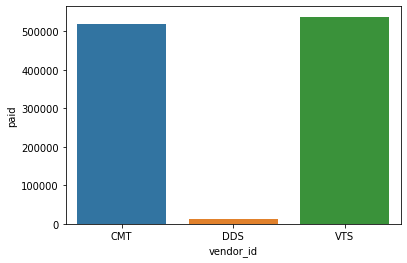

In [17]:
vendor_imp =data.groupby(['vendor_id'])['tip_paid'].count().reset_index().rename(columns={'tip_paid':'paid'})
sns.barplot(x='vendor_id',y='paid',data=vendor_imp)
vendor_imp.head()

,vendor_id,amount
0,CMT,519080
1,DDS,12269
2,VTS,537557


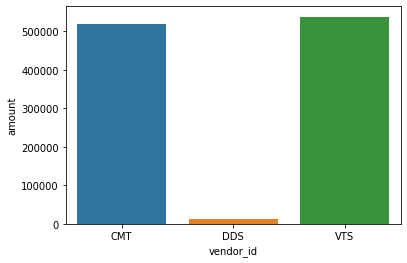

In [18]:
vendor_impamount =data.groupby(['vendor_id'])['tip_amount'].count().reset_index().rename(columns={'tip_amount':'amount'})
sns.barplot(x='vendor_id',y='amount',data=vendor_impamount)
vendor_impamount.head()

,payment_type,paid
0,CRD,462328
1,CSH,603924
2,NOC,1139
3,UNK,1515


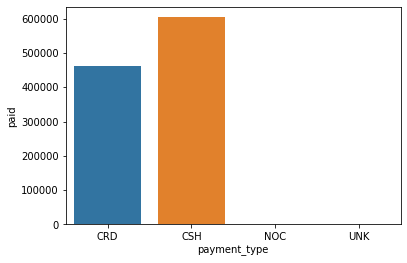

In [19]:
payment_imp =data.groupby(['payment_type'])['tip_paid'].count().reset_index().rename(columns={'tip_paid':'paid'})
sns.barplot(x='payment_type',y='paid',data=payment_imp)
payment_imp.head()

,payment_type,amount
0,CRD,462328
1,CSH,603924
2,NOC,1139
3,UNK,1515


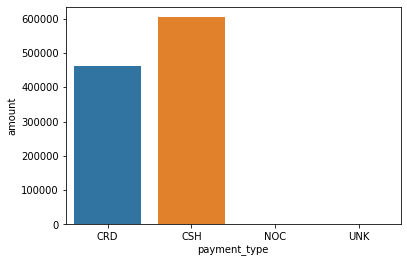

In [20]:
payment_impamount =data.groupby(['payment_type'])['tip_amount'].count().reset_index().rename(columns={'tip_amount':'amount'})
sns.barplot(x='payment_type',y='amount',data=payment_impamount)
payment_impamount.head()

In [21]:
print(data.columns)

Index(['vendor_id', 'passenger_count', 'payment_type', 'fare_amount',
       'tip_amount', 'tip_paid', 'p_weekday', 'time_duration', 'p_hour',
       'p_year', 'p_month', 'actual_dist', 'pickup_long', 'pickup_lat',
       'dropoff_long', 'dropoff_lat'],
      dtype='object')


> The Features generated and which we shall be using to build the models are 
time_duration, actual distance (generated from latitude and longitudes), hour, month, weekday, year, vendor and passenger count

###### Transforming Features into Categorical variables 

In [22]:
Vendors = pd.get_dummies(data['vendor_id'], prefix = 'vendor_=',drop_first = True)
Payments = pd.get_dummies(data['payment_type'], prefix = 'payment_=',drop_first = True)
data['p_weekday'] = data['p_weekday'].map({'Sunday':0,'Monday':1, 'Tuesday':2,'Wednesday':3, 'Thursday':4,'Friday':5, 'Saturday':6})

taxi = pd.concat([data.drop(['vendor_id','payment_type'], axis = 1),Vendors,Payments], axis = 1)

In [23]:
taxi.corr(method='pearson')

,passenger_count,fare_amount,tip_amount,tip_paid,p_weekday,time_duration,p_hour,p_year,p_month,actual_dist,vendor_=_DDS,vendor_=_VTS,payment_=_CSH,payment_=_NOC,payment_=_UNK
passenger_count,1.000000,0.009517,-0.015169,-0.023972,0.013341,0.009871,0.047319,0.001446,0.004050,0.002529,-0.026690,0.308954,0.022998,-0.010721,0.003271
fare_amount,0.009517,1.000000,0.376033,0.132488,0.027545,0.850982,0.047044,0.175771,0.037493,0.792264,-0.018653,-0.004092,-0.137777,0.002670,0.008390
tip_amount,-0.015169,0.376033,1.000000,0.826315,0.006137,0.295419,0.049100,0.230543,0.004611,0.288879,-0.039266,0.009144,-0.805051,-0.022967,0.015302
tip_paid,-0.023972,0.132488,0.826315,1.000000,-0.001403,0.094932,0.026777,0.225064,-0.002481,0.109161,-0.042583,0.002898,-0.974211,-0.027821,0.019527
p_weekday,0.013341,0.027545,0.006137,-0.001403,1.000000,0.045811,0.027748,-0.003167,0.000548,0.004304,0.005906,0.010322,0.000753,-0.000967,-0.001895
time_duration,0.009871,0.850982,0.295419,0.094932,0.045811,1.000000,-0.022586,0.058883,0.044149,0.633692,0.015934,-0.000613,-0.098696,0.001191,0.003363
p_hour,0.047319,0.047044,0.049100,0.026777,0.027748,-0.022586,1.000000,0.005894,-0.001462,0.123067,-0.000962,0.019810,-0.028702,0.001202,-0.001325
p_year,0.001446,0.175771,0.230543,0.225064,-0.003167,0.058883,0.005894,1.000000,-0.111489,-0.002262,-0.143234,0.009784,-0.232743,0.005419,0.027022
p_month,0.004050,0.037493,0.004611,-0.002481,0.000548,0.044149,-0.001462,-0.111489,1.000000,0.007242,-0.003699,-0.000103,0.002185,0.001155,0.003151
actual_dist,0.002529,0.792264,0.288879,0.109161,0.004304,0.633692,0.123067,-0.002262,0.007242,1.000000,-0.000632,-0.016007,-0.110912,-0.001801,0.000626


##### Decision Tree Classifier for Tip paid

In [24]:
# a. For tip_paid 
# We shall not use tip_amount for tip_paid, as they are highly correlated

x_train, x_test, y_train, y_test = model_selection.train_test_split(taxi.drop(columns = {'tip_amount','tip_paid','payment_=_CSH','payment_=_NOC','payment_=_UNK'}, axis=1), taxi['tip_paid'], test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [25]:
dtc = tree.DecisionTreeClassifier()
dtc_0 = dtc.fit(x_train, y_train)

y_pred = dtc.predict(x_test)
y_val = dtc.predict(x_val)
y_pred_train = dtc.predict(x_train)


report = """
The evaluation report is:
Confusion Matrix:
{}
Score of Test data: {}
Score of Training data: {}
Score of Valuation data: {}
Precision: {}
Recall: {}
ROC: {}
F1: {}
""".format(confusion_matrix(y_test, y_pred),
           accuracy_score(y_test, y_pred),
           dtc.score(x_train, y_train),
          dtc.score(x_val, y_val), 
          precision_score(y_test, y_pred),
          recall_score(y_test, y_pred),
          roc_auc_score(y_test, y_pred),
          f1_score(y_test, y_pred))
print(report)


The evaluation report is:
Confusion Matrix:
[[74700 48675]
 [47122 43285]]
Score of Test data: 0.5518939854618256
Score of Training data: 1.0
Score of Valuation data: 1.0
Precision: 0.4706937799043062
Recall: 0.4787792980632031
ROC: 0.5421252113416319
F1: 0.4747021116759062



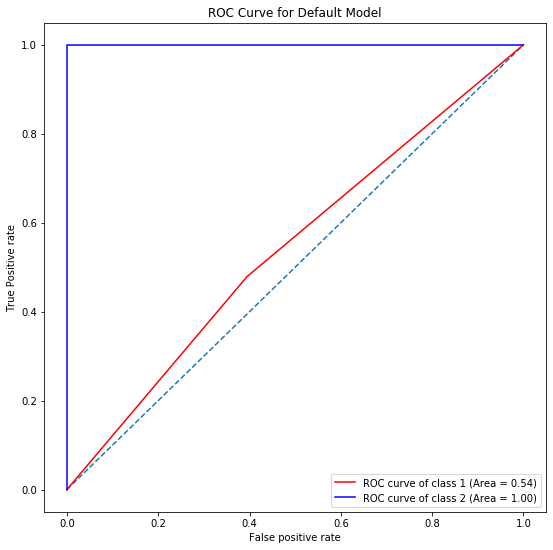

In [26]:
#Building ROC Curve for Default model 
roc_auc = dict()
fpr = dict()
tpr = dict()
fpr[0], tpr[0], _ = metrics.roc_curve(y_test, y_pred)
fpr[1], tpr[1], _ = metrics.roc_curve(y_train, y_pred_train)
for i in range(2):
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
plt.figure(figsize = (9, 9))    
plt.plot([0, 1], [0, 1], linestyle='--')

colors = (['red', 'blue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label='ROC curve of class {0} (Area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))    

plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve for Default Model')
plt.legend(loc="lower right")
plt.show()

The curve shows that area under the curve is very low for test data vs training, We have to better tune the model with hyperparameters - providing it a boundary to avoid growing endlessly.

4. c) We can see signs of overfitting as the score of Training data is much higher than Test data. (1 for training and 0.54 for test). The curve also shows that area under the curve is lower for test data vs training, indicating overfitting.
 To avoid overfitting, we have to better tune the model with hyperparameters - providing it a boundary to avoid growing endlessly.

###### Selecting the best hyperparameters -- Changing Max depth and  Criterion 

In [27]:
for max_depth in range(1, 12):
    t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(t, x_val, y_val, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))
    
for max_depth in range(1, 12):
    t = tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    scores = cross_val_score(t, x_val, y_val, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))

Max depth: 1, Accuracy: 0.57 (+/- 0.00)
Max depth: 2, Accuracy: 0.60 (+/- 0.00)
Max depth: 3, Accuracy: 0.60 (+/- 0.01)
Max depth: 4, Accuracy: 0.60 (+/- 0.01)
Max depth: 5, Accuracy: 0.61 (+/- 0.01)
Max depth: 6, Accuracy: 0.61 (+/- 0.01)
Max depth: 7, Accuracy: 0.61 (+/- 0.01)
Max depth: 8, Accuracy: 0.61 (+/- 0.00)
Max depth: 9, Accuracy: 0.61 (+/- 0.01)
Max depth: 10, Accuracy: 0.61 (+/- 0.01)
Max depth: 11, Accuracy: 0.61 (+/- 0.01)
Max depth: 1, Accuracy: 0.57 (+/- 0.00)
Max depth: 2, Accuracy: 0.60 (+/- 0.00)
Max depth: 3, Accuracy: 0.60 (+/- 0.01)
Max depth: 4, Accuracy: 0.60 (+/- 0.01)
Max depth: 5, Accuracy: 0.61 (+/- 0.01)
Max depth: 6, Accuracy: 0.61 (+/- 0.01)
Max depth: 7, Accuracy: 0.61 (+/- 0.00)
Max depth: 8, Accuracy: 0.61 (+/- 0.00)
Max depth: 9, Accuracy: 0.61 (+/- 0.01)
Max depth: 10, Accuracy: 0.61 (+/- 0.01)
Max depth: 11, Accuracy: 0.60 (+/- 0.01)


In [28]:
new_treegini=tree.DecisionTreeClassifier(criterion='gini',splitter ='best', max_depth=7, min_samples_split=10, 
                                           min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features=None, 
                                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                           min_impurity_split=None, class_weight=None, presort=False)

new_treeent=tree.DecisionTreeClassifier(criterion='entropy',splitter ='best', max_depth=8, min_samples_split=10, 
                                           min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features=None, 
                                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                           min_impurity_split=None, class_weight=None, presort=False)    
new_treegini.fit(x_train,y_train)
y_pred_new= new_treegini.predict(x_test)
y_pred_new_train= new_treegini.predict(x_train)

new_treeent.fit(x_train,y_train)
y_pred_newe= new_treeent.predict(x_test)
y_pred_new_traine= new_treeent.predict(x_train)

print("Score on test data ", accuracy_score(y_test,y_pred_new))
print("Score on training data ", accuracy_score(y_train, y_pred_new_train))
print("Precision:", precision_score(y_test, y_pred_new))
print("Recall:", recall_score(y_test, y_pred_new))
print("F1 score:", f1_score(y_test, y_pred_new))
print("ROC score:", roc_auc_score(y_test, y_pred_new))

print("Score on test data ", accuracy_score(y_test,y_pred_newe))
print("Score on training data ", accuracy_score(y_train, y_pred_new_traine))
print("Precision:", precision_score(y_test, y_pred_newe))
print("Recall:", recall_score(y_test, y_pred_newe))
print("F1 score:", f1_score(y_test, y_pred_newe))
print("ROC score:", roc_auc_score(y_test, y_pred_newe))

C:\Users\himani reddy\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
C:\Users\himani reddy\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


Score on test data  0.6248187405862047
Score on training data  0.6237035867615652
Precision: 0.5758770494242271
Recall: 0.42814162620151097
F1 score: 0.49114013995597033
ROC score: 0.5985409245495903
Score on test data  0.6260349327819928
Score on training data  0.625698911999579
Precision: 0.5734839543640757
Recall: 0.45146946585994446
F1 score: 0.5052141676826815
ROC score: 0.6027114299917757


* 4.a) Here i have chosen accuracy as a performance measure, given that the dataset is not specifically biased and using this metric, the model using entropy as the criterion performs marginally better than the model using gini criterion. 

Tuning can help in improving model performance by helping put restrictions to avoid overfitting and underfitting.  For example, chosing gini over entropy criterion for calculating information gain helps improve model performance. Max depth also helps to improve accuracy. Min_sample_split and max_leaf_node provide a boundary so that tree doesnt grow infinitely.

> The best combination or better model accuracy has been found to be for the parameters of max_depth = 8 , criterion = 'entropy', splitter = 'best'

##### Decision Tree Regressor for Tip amount

In [29]:
x_train1, x_test1, y_train1, y_test1 = model_selection.train_test_split(taxi.drop(columns = {'tip_amount','tip_paid'}, axis=1), taxi['tip_amount'], test_size=0.2, random_state=1)
x_train1, x_val1, y_train1, y_val1 = model_selection.train_test_split(x_train1, y_train1, test_size=0.2, random_state=1)

In [30]:
# Baseline Model 
avg_tip=round(np.mean(y_train1),2)
bpred=np.repeat(avg_tip,y_test1.shape[0])
brmse=np.sqrt(mean_squared_error(bpred, y_test1))
print("Basline RMSE of baseline model is :",brmse)

Basline RMSE of baseline model is : 1.1000486472499877


In [31]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(x_train1, y_train1)

y_pred1 = dtr.predict(x_test1)
y_pred_val1 = dtr.predict(x_val1)
y_pred_train1 = dtr.predict(x_train1)

print('RMSE for test: {}'.format(np.sqrt(mean_squared_error(y_test1, y_pred1))))
print('RMSE for validation: {}'.format(np.sqrt(mean_squared_error(y_val1, y_pred_val1))))
print('RMSE for train: {}'.format(np.sqrt(mean_squared_error(y_train1, y_pred_train1))))

RMSE for test: 0.7240544322071081
RMSE for validation: 0.725208703610101
RMSE for train: 2.2121554137469328e-17


###### Selecting the best hyperparameters -- Changing Max depth and  min_samples_leaf

In [32]:
x_train1.shape

(684099, 17)

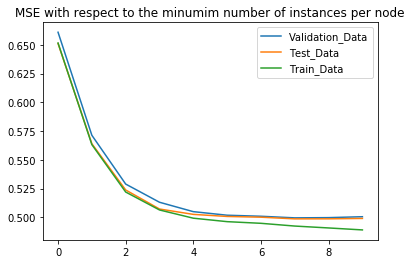

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111) 
MSEmse = []
MSEtes = []
MSEtra = []

for j in range(1,11):
    rm = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=50,max_depth = j)   
    rm.fit(x_train1,y_train1)
    pred_val = rm.predict(x_val1)
    pred_test = rm.predict(x_test1)
    pred_train = rm.predict(x_train1)
    MSEmse.append(np.sqrt(mean_squared_error(y_val1, pred_val)))
    MSEtes.append(np.sqrt(mean_squared_error(y_test1, pred_test)))
    MSEtra.append(np.sqrt(mean_squared_error(y_train1,pred_train)))

ax.plot(MSEmse,label='Validation_Data')
ax.plot(MSEtes,label='Test_Data')
ax.plot(MSEtra,label='Train_Data')
ax.legend()
ax.set_title('MSE with respect to the minumim number of instances per node')
plt.show()

* Letting max_depth go unattended leads to overfitting and on the other hand low max_depth results in underfitting. Hence, choosing the best max_depth by comparing test and train mse values. 
* Choosing the max depth of 5 as both validation and test scores are minimal at the depth of 5 and now modifying the instances is observed below 

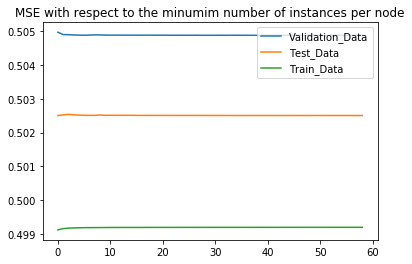

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111) 
MSEmse = []
MSEtes = []
MSEtra = []

for j in range(1,60):
    rm = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=j,max_depth = 5)   
    rm.fit(x_train1,y_train1)
    pred_val = rm.predict(x_val1)
    pred_test = rm.predict(x_test1)
    pred_train = rm.predict(x_train1)
    MSEmse.append(np.sqrt(mean_squared_error(y_val1, pred_val)))
    MSEtes.append(np.sqrt(mean_squared_error(y_test1, pred_test)))
    MSEtra.append(np.sqrt(mean_squared_error(y_train1,pred_train)))

ax.plot(MSEmse,label='Validation_Data')
ax.plot(MSEtes,label='Test_Data')
ax.plot(MSEtra,label='Train_Data')
ax.legend()
ax.set_title('MSE with respect to the minumim number of instances per node')
plt.show()

In [62]:
for ind, s in enumerate(MSEmse):
    if s == min(MSEmse):
        print (ind, s)

41 0.5048793720629468


* 4.b) With respect to RMSE, the baseline model gave a RMSE of 1.102, the basic regressor with default parameters gave a RMSE of 0.721, Further tuning the model based on min_samples_leaf and max_depth, the minimum RMSE is observed at max_depth of 5 and min_samples_leaf of around 42 as depicted in the above graph

* There is no visible difference in the RMSE values from 10-60 instances.  

* The RMSE is observed as 0.5, which is an improvement over our default regressor

Alternatively one could have used Grid Search or Randomized Search, i however choose to do manual analysis for this one for initial understanding of the working and to know the nitty gritties.  

In [67]:
dtr0 = tree.DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 42)
dtr0.fit(x_train1, y_train1)

y_pred0 = dtr0.predict(x_test1)
y_pred_val0 = dtr0.predict(x_val1)
y_pred_train0 = dtr0.predict(x_train1)

print('RMSE for test: {}'.format(np.sqrt(mean_squared_error(y_test1, y_pred0))))
print('RMSE for validation: {}'.format(np.sqrt(mean_squared_error(y_val1, y_pred_val0))))
print('RMSE for train: {}'.format(np.sqrt(mean_squared_error(y_train1, y_pred_train0))))

RMSE for test: 0.5025056215471312
RMSE for validation: 0.5048793720629469
RMSE for train: 0.4991942982044296


Original mdoel's performance is 
MSE for test: 0.7216854909084367
MSE for validation: 0.7143340413223662
whilst the tuned model is observed to perform better with RMSE values such as 
RMSE for test: 0.5025056215471312
RMSE for validation: 0.5048793720629469


 *---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Tuning can help in improving model performance by helping put restrictions to avoid overfitting and underfitting.  For example, chosing entropy over gini index for calculating information gain helps improve model performance. Although it has been proven that there is only 2% difference in the results of gini impurity method and entropy method. Max depth also helps to improve accuracy. Min_sample_split and max_leaf_node provide a boundary so that tree doesnt grow infinitely.

##### Decision Tree Regressor for Fare amount

In [71]:
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(taxi.drop(columns = {'tip_paid','fare_amount'}, axis=1), taxi['fare_amount'], test_size=0.2, random_state=1)
x_train2, x_val2, y_train2, y_val2 = model_selection.train_test_split(x_train2, y_train2, test_size=0.2, random_state=1)


#Baseline Model
avg_fare=round(np.mean(y_train2),2)
bpred2=np.repeat(avg_fare,y_test2.shape[0])
brmse2=np.sqrt(mean_squared_error(bpred2, y_test2))
print("RMSE of baseline model is :",brmse2)


dtr2 = tree.DecisionTreeRegressor()
dtr2.fit(x_train2, y_train2)

y_pred2 = dtr2.predict(x_test2)
y_pred_val2 = dtr2.predict(x_val2)
y_pred_train2 = dtr2.predict(x_train2)

print('MSE for test: {}'.format(np.sqrt(mean_squared_error(y_test2, y_pred2))))
print('MSE for validation: {}'.format(np.sqrt(mean_squared_error(y_val2, y_pred_val2))))
print('MSE for train: {}'.format(np.sqrt(mean_squared_error(y_train2, y_pred_train2))))

RMSE of baseline model is : 4.010557361185998
MSE for test: 1.6265984145634247
MSE for validation: 1.6700557964921905
MSE for train: 3.412257177555895e-16


###### Selecting the best hyperparameters -- Changing Max depth and  Min_sample_leaf

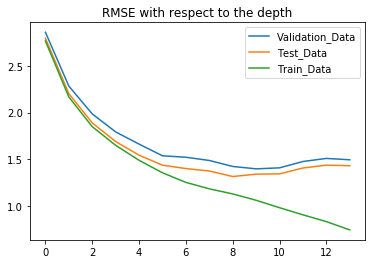

In [72]:
fig = plt.figure()
ax2 = fig.add_subplot(111) 
rmsetest =[]
rmseval =[]
rmsetrain =[]
for j in range(1,15):
    rm2 = tree.DecisionTreeRegressor(criterion="mse",max_depth =j)   
    rm2.fit(x_train2,y_train2)
    pred_val2 = rm2.predict(x_val2)
    pred_test2 = rm2.predict(x_test2)
    pred_train2 = rm2.predict(x_train2)
    rmsetrain.append(np.sqrt(mean_squared_error(y_train2, pred_train2)))
    rmsetest.append(np.sqrt(mean_squared_error(y_test2, pred_test2)))
    rmseval.append(np.sqrt(mean_squared_error(y_val2, pred_val2)))

ax2.plot(rmseval,label='Validation_Data')
ax2.plot(rmsetest,label='Test_Data')
ax2.plot(rmsetrain,label='Train_Data')
ax2.legend()
ax2.set_title('RMSE with respect to the depth')
plt.show()

Choosing the max_depth as 8

In [75]:
for j in range(1,20):
    rm2 = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=j,max_depth = 8)   
    rm2.fit(x_train2,y_train2)
    pred_val2 = rm2.predict(x_val2)
    pred_test2 = rm2.predict(x_test2)
    print(j,': ', 'val: ', np.sqrt(mean_squared_error(y_val2, pred_val2)),'test: ',np.sqrt(mean_squared_error(y_test2, pred_test2)))

1 :  val:  1.4497416691996527 test:  1.3452602678576495
2 :  val:  1.44907760847464 test:  1.3408468460018956
3 :  val:  1.4407063410722667 test:  1.3334109472319617
4 :  val:  1.4447447860620044 test:  1.3311094442054108
5 :  val:  1.4444806539649977 test:  1.3260842979294822
6 :  val:  1.4366920138873724 test:  1.3226263683228394
7 :  val:  1.4359635127540216 test:  1.3239741981494548
8 :  val:  1.4378796879191027 test:  1.3263864454195278
9 :  val:  1.4343313799599735 test:  1.3327955911571874
10 :  val:  1.4355602999723318 test:  1.3320032659192222
11 :  val:  1.4320944170750214 test:  1.3261129923454087
12 :  val:  1.433255579481627 test:  1.327501282433435
13 :  val:  1.434567178723204 test:  1.330809715671227
14 :  val:  1.4363104306773646 test:  1.3288210506133395
15 :  val:  1.443022996461545 test:  1.3261634698503095
16 :  val:  1.4429840425452634 test:  1.3258127542128961
17 :  val:  1.442879124290356 test:  1.3259859844116413
18 :  val:  1.442417582392324 test:  1.326444229

* The least RMSE of around 1.432 are observed at around max_depth 8, which is an improvement over the baseline and initial models 

* The RMSE values show an increasing trend after the minimum sample size of 11

Hence the ideal model will be 

dtr2 = tree.DecisionTreeRegressor(max_depth = 8, min_samples_leaf  = 11)

In [76]:
dtr3 = tree.DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 11)
dtr3.fit(x_train2, y_train2)

y_pred3 = dtr3.predict(x_test2)
y_pred_val3 = dtr3.predict(x_val2)
y_pred_train3 = dtr3.predict(x_train2)

print('MSE for test: {}'.format(np.sqrt(mean_squared_error(y_test2, y_pred3))))
print('MSE for validation: {}'.format(np.sqrt(mean_squared_error(y_val2, y_pred_val3))))
print('MSE for train: {}'.format(np.sqrt(mean_squared_error(y_train2, y_pred_train3))))

MSE for test: 1.3261129923454087
MSE for validation: 1.4320944170750214
MSE for train: 1.2414854857591882


The original model produced an rmse of 
MSE for test: 1.6460324136310556
MSE for validation: 1.54096947786086
    Whereas the tuned model is observed to enhance the performance with
MSE for test: 1.3261129923454087
MSE for validation: 1.4320944170750214

>

>

### Question 3: Boosted Trees

###### For Tip Paid

* Connsidering the accuracy score for classifiers and mse for regressors as objective metric

In [78]:
from sklearn import ensemble, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [ ]:
# Random Forest 
params_rforest = [ {'criterion': ['gini', 'entropy'], 'n_estimators': [10], 'max_depth': [4,5,6,7,8,9,10], 'min_samples_split': list(range(2, 11, 2))}]

accuracy = make_scorer(accuracy_score)

clf1 = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), params_rforest, scoring = accuracy, cv = 5)
clf1.fit(x_train, y_train)
print('RandomForest Score Best:', clf1.best_score_)
print('RandomForest Parameters Best: ', clf1.best_params_)

RandomForest Score Best: 0.9888443553774215
RandomForest Parameters Best:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 10}

In [326]:
#Adaboost
params_ada = {'n_estimators': list(range(5, 100, 20)),'learning_rate': (0.5, 1.0, 1.5, 2.0, 2.5, 3.0),'algorithm': ['SAMME', 'SAMME.R']}

clf2 = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), params_ada, scoring = accuracy, cv = 5)
clf2.fit(x_train, y_train)
print('AdaBosst Score Best:', clf2.best_score_)
print('AdaBoost Parameters Best: ', clf2.best_params_)

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\ana

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\A

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuu

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:

C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\hreddy1\AppData\Local\Continuum\anaconda3\lib\site-

AdaBosst Score Best: 0.6292221249270286
AdaBoost Parameters Best:  {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 85}


AdaBosst Score Best: 0.9889779559118237
AdaBoost Parameters Best:  {'n_estimators': 65, 'algorithm': 'SAMME', 'learning_rate': 1.5}

In [334]:
#scoring on test data
y_pred = clf2.predict(x_test)
print('Accuracy on test data: ',accuracy_score(y_test, y_pred))

Accuracy on test data:  0.6292696823365682


>

In [ ]:
# Gradient Boost
params_gb = {'loss': ['deviance', 'exponential'],
              'criterion': ['friedman_mse'],
              'max_depth': list(range(5, 15, 5)),
              'min_samples_split': list(range(2, 21, 2)),
              'max_features': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

clf3 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), params_gb, scoring = accuracy, cv = 5)
clf3.fit(x_train, y_train)
print('GBoost Score Best:', clf3.best_score_)
print('GBoost Parameters Best:', clf3.best_params_)

GBoost Score Best: 0.9890002226675574
GBoost Parameters Best: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 20, 'max_features': 0.01, 'loss': 'deviance'}

###### For Tip Amount

In [302]:
from sklearn import ensemble, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

scorer = make_scorer(mean_squared_error)

In [337]:
# Random Forest 

params_rforest1 = [ {'criterion': ["mse"], 'n_estimators': [10], 'max_depth': [8, 9, 10, 11], 'min_samples_split': np.arange(2, 11, 2)}]

Reg1 = model_selection.GridSearchCV(ensemble.RandomForestRegressor(), params_rforest1, scoring = scorer, cv = 5)
Reg1.fit(x_train1, y_train1)
print('RandomForest Score Best:', Reg1.best_score_)
print('RandomForest Parameters Best: ', Reg1.best_params_)

KeyboardInterrupt: 

>

In [329]:
#Adaboost
params_ada1 = {'n_estimators': list(range(5, 50, 10)),'learning_rate': ( 1.0, 1.5, 2.0, 2.5),'loss': ['linear', 'exponential']}

Reg2 = model_selection.GridSearchCV(ensemble.AdaBoostRegressor(), params_ada1, scoring = scorer, cv = 5)
Reg2.fit(x_train1, y_train1)
print('AdaBosst Score Best:', Reg2.best_score_)
print('AdaBoost Parameters Best: ', Reg2.best_params_)

AdaBosst Score Best: 5.144714646876752
AdaBoost Parameters Best:  {'learning_rate': 2.5, 'loss': 'exponential', 'n_estimators': 45}


In [333]:
#scoring on test data
y_pred1 = Reg2.predict(x_test1)
print('Rmse on test data: ',np.sqrt(mean_squared_error(y_test1, y_pred1)))

Rmse on test data:  1.9621164282054329


>

In [ ]:
# Gradient Boost
params_gb1 = {'loss': ['ls', 'huber'],
              'criterion': "mse",
              'max_depth': list(range(5, 15, 5)),'max_features': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

#'min_samples_split': list(range(2, 21, 2)),

Reg3 = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), params_gb1, scoring = scorer, cv = 5)
Reg3.fit(x_train1, y_train1)
print('GBoost Score Best:', Reg3.best_score_)
print('GBoost Parameters Best:', Reg3.best_params_)

###### For Fare Amount

In [331]:
# Random Forest 
params_rforest2 = [ {'criterion': ["mse"] , 'n_estimators': [10], 'max_depth': [8, 9, 10,11,12], 'min_samples_split': np.arange(2, 11, 2)}]

Reg4 = model_selection.GridSearchCV(ensemble.RandomForestRegressor(), params_rforest2, scoring = scorer, cv = 5)
Reg4.fit(x_train2, y_train2)
print('RandomForest Score Best:', Reg4.best_score_)
print('RandomForest Parameters Best: ', Reg4.best_params_)

RandomForest Score Best: 1.5508584318711336
RandomForest Parameters Best:  {'criterion': 'mse', 'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 10}


In [335]:
#scoring on test data
y_pred2 = Reg4.predict(x_test2)
print('Rmse on test data by RF regressor: ',np.sqrt(mean_squared_error(y_test2, y_pred2)))

Rmse on test data by RF regressor:  1.3906140268658302


>

In [328]:
#Adaboost
params_ada2 = {'n_estimators': list(range(5, 50, 10)),'learning_rate': ( 1.0, 1.5, 2.0, 2.5),'loss': ['linear', 'exponential']}

Reg5 = model_selection.GridSearchCV(ensemble.AdaBoostRegressor(), params_ada2, scoring = scorer, cv = 5)
Reg5.fit(x_train2, y_train2)
print('AdaBoost Score Best:', Reg5.best_score_)
print('AdaBoost Parameters Best: ', Reg5.best_params_)

AdaBosst Score Best: 249.36676919764145
AdaBoost Parameters Best:  {'learning_rate': 2.5, 'loss': 'exponential', 'n_estimators': 45}


In [336]:
#scoring on test data
y_pred2 = Reg5.predict(x_test2)
print('Rmse on test data by Adaboost Regressor: ',np.sqrt(mean_squared_error(y_test2, y_pred2)))

Rmse on test data by Adaboost Regressor:  15.144752304851306


>

In [ ]:
# Gradient Boost
params_gb2 = {'loss': ['ls', 'huber'],
              'criterion': "mse",
              'max_depth': list(range(5, 15, 5)),'max_features': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

Reg6 = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), params_gb2, scoring = rmse, cv = 5)
Reg6.fit(x_train2, y_train2)
print('GBoost Score Best:', Reg6.best_score_)
print('GBoost Parameters Best:', Reg6.best_params_)

*******Note: The models have been running for the past 2-3 days.
* As Adaboost happened to be comparitively faster (and given the PC's preocessing power), hence executed those boosted trees first with limited number of estimators 
* Gradient Boosting as it requires more execution time and given the time limitation, is chosed to execute at the end
* Also limited the choice of estimators for the same reason (Adaboost for classifier has been provided the estimators in the range of 5 - 100 and the subsequent models have been given either a fixed estimator or a reduced range

The performance score for the Random forest ensemble model and Adaboost classifier showed signs of improvement in score over the tuned decision tree classifier.

Also observed is the absence of signs of overfitting of train data. ALthough it is so possible that adaboost tries to fit every data point, but it does not result in overfitting the model

Also mean squared error has been used as a metric to score the regression models